In this notebook, we explore the implementation of image recognition task for the cats_vs_dogs dataset using SIFT & SURF feature descriptors. A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.

We'll leverage the power of classical ML models like SVDD and SVM, as well as deep learning models like CNNs to achieve accurate digit recognition.

## 1. Load the libraries and dataset

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time

In [27]:
# Parameter Setting

IMG_SIZE = 160
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
DATASET = 'cats_vs_dogs' #replace with other dataset from Tensorflow

In [28]:
class DataLoader(object):
    def __init__(self, image_size, batch_size):

        self.image_size = image_size
        self.batch_size = batch_size

        # Load the dataset
        (self.train_data_raw, self.validation_data_raw, self.test_data_raw), self.metadata = tfds.load(
            DATASET,
            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # Split the 'train' split into 80%, 10%, and 10%
            with_info=True,
            as_supervised=True
        )

        # Get the number of train examples
        self.num_train_examples = self.metadata.splits['train'].num_examples*80/100
        self.get_label_name = self.metadata.features['label'].int2str

        # Pre-process data
        self._prepare_data()
        self._prepare_batches()

    # Resize all images to image_size x image_size
    def _prepare_data(self):
        self.train_data = self.train_data_raw.map(self._resize_sample)
        self.validation_data = self.validation_data_raw.map(self._resize_sample)
        self.test_data = self.test_data_raw.map(self._resize_sample)

    # Resize one image to image_size x image_size
    def _resize_sample(self, image, label):
        image = tf.cast(image, tf.float32)
        image = (image/127.5) - 1
        image = tf.image.resize(image, (self.image_size, self.image_size))
        return image, label

    def _prepare_batches(self):
        self.train_batches = self.train_data.shuffle(1000).batch(self.batch_size)
        self.validation_batches = self.validation_data.batch(self.batch_size)
        self.test_batches = self.test_data.batch(self.batch_size)

    # Get defined number of  not processed images
    def get_random_raw_images(self, num_of_images):
        random_train_raw_data = self.train_data_raw.shuffle(1000)
        return random_train_raw_data.take(num_of_images)

    # Get defined number of processed images
    def get_random_resized_images(self, num_of_images):
        random_train_data = self.train_data.shuffle(1000)
        return random_train_data.take(num_of_images)

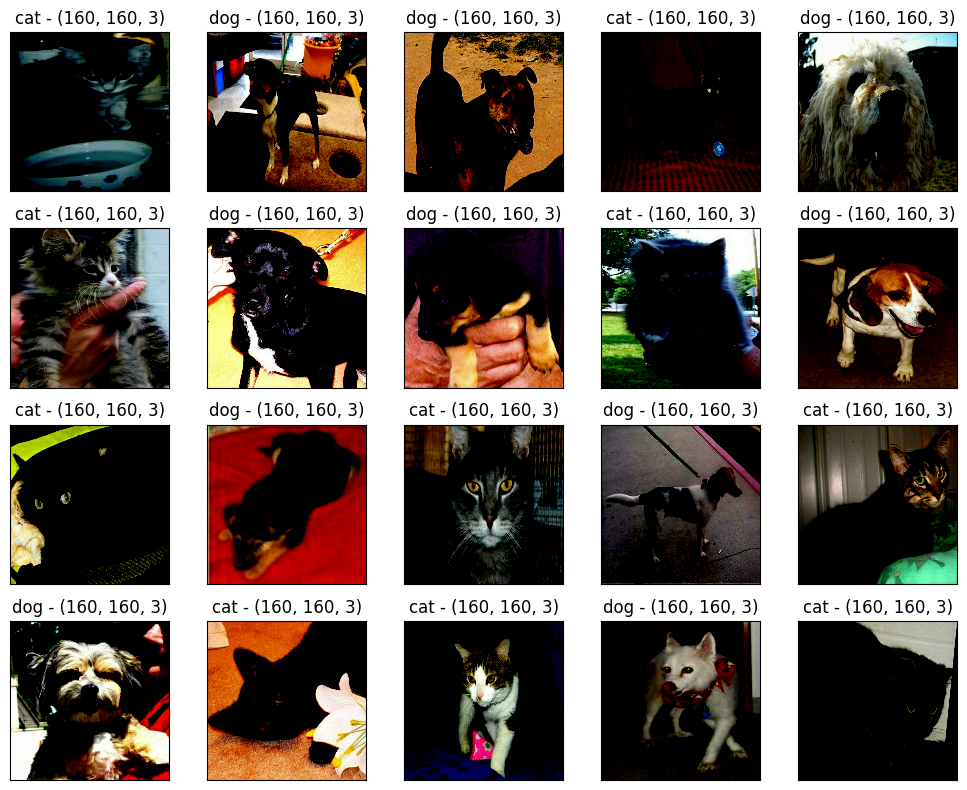

In [29]:
data_loader = DataLoader(IMG_SIZE, BATCH_SIZE)

# show image samples
plt.figure(figsize=(10, 8))
i = 0
for img, label in data_loader.get_random_resized_images(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title("{} - {}".format(data_loader.get_label_name(label), img.shape))
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.tight_layout()
plt.show()

In [34]:
# 2. 特征提取 (SIFT 和 ORB)
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    sift_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 转为灰度图
        keypoints, descriptors = sift.detectAndCompute(gray, None)  # 提取关键点和描述符
        sift_features.append(descriptors)
    return sift_features

def extract_orb_features(images):
    orb = cv2.ORB_create()
    orb_features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # 转为灰度图
        keypoints, descriptors = orb.detectAndCompute(gray, None)  # 提取关键点和描述符
        orb_features.append(descriptors)
    return orb_features

# 3. 特征提取并将特征展平以供 SVM 使用
def flatten_features(features_list):
    flat_features = []
    for feature in features_list:
        if feature is not None:
            flat_features.append(feature.flatten())
        else:
            flat_features.append(np.zeros(32))  # 用零填充缺少的特征
    return np.array(flat_features)

## 2. Feature Engineering

In [31]:
import cv2
import numpy as np
from skimage.color import rgb2gray

def get_features(dataset, method, sigma=None):
    """
    Extract features from a set of images using SIFT or SURF.

    Parameters:
        input_datastore (list): List of file paths to the images.
        method (str): Feature extraction method ('SIFT' or 'SURF').
        sigma (float, optional): Sigma value for SIFT feature detection.

    Returns:
        features_out (np.ndarray): Placeholder for unused PCA features (25 columns, not used here).
        features_out2 (np.ndarray): Feature scales (columns 1–5) and metrics (columns 6–10).
    """
    size_ds = len(dataset)
    # features_out = np.zeros((size_ds, 25))  # Unused in this implementation
    features_out = np.zeros((size_ds, 10))

    for i, (img, _) in enumerate(dataset):
        # Read and convert image to grayscale
        # img = cv2.imread(image_path)
        img_gray = rgb2gray(img) if len(img.shape) == 3 else img

        # Initialize feature detector
        if method == 'SIFT':
            sift = cv2.SIFT_create(contrastThreshold=sigma if sigma else 0.04)
            keypoints, _ = sift.detectAndCompute((img_gray * 255).astype('uint8'), None)
        elif method == 'SURF':
            surf = cv2.xfeatures2d.SURF_create()
            keypoints, _ = surf.detectAndCompute((img_gray * 255).astype('uint8'), None)
        else:
            raise ValueError(f"Unknown method: {method}")

        # Select strongest 5 keypoints
        if len(keypoints) > 0:
            keypoints = sorted(keypoints, key=lambda k: k.response, reverse=True)
            strongest_keypoints = keypoints[:5]
            scales = [kp.size for kp in strongest_keypoints]
            metrics = [kp.response for kp in strongest_keypoints]
        else:
            strongest_keypoints = []
            scales = []
            metrics = []
            print("Warning - not enough feature points!")

        # Fill features_out2 matrix
        diff = 5 - len(strongest_keypoints)
        features_out[i, :5] = scales + [0] * diff
        features_out[i, 5:] = metrics + [0] * diff

    return features_out


In [32]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# normalize features
def normalize_features(features):
    """
    Normalize the features using z-score normalization.

    Parameters:
        features (np.ndarray): Extracted features (e.g., scales and metrics).

    Returns:
        np.ndarray: Normalized features with mean 0 and std deviation 1.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(features)

# features_train_normalized = normalize_features(feature_train)
# print("Mean of normalized features:", np.mean(features_train_normalized, axis=0))
# print("Std of normalized features:", np.std(features_train_normalized, axis=0))

## 3. Training a classifier

In [33]:
start_time_FE = time.time()
# feature extraction
features_train = get_features(data_loader.train_data, 'SIFT')
features_validation = get_features(data_loader.validation_data, 'SIFT')
features_test = get_features(data_loader.test_data, 'SIFT')
end_time_FE = time.time()
print(f"Feature extraction time: {end_time_FE - start_time_FE} seconds")

# feature normalization
features_train_normalized = normalize_features(features_train)
features_validation_normalized = normalize_features(features_validation)
features_test_normalized = normalize_features(features_test)

# get labels
labels_train = np.array([label.numpy() for _, label in data_loader.train_data])
labels_validation = np.array([label.numpy() for _, label in data_loader.validation_data])
labels_test = np.array([label.numpy() for _, label in data_loader.test_data])

# prepare data(non-cross-validation)
X_train = features_train_normalized
y_train = labels_train

X_validation = features_validation_normalized
y_validation = labels_validation

X_test = features_test_normalized
y_test = labels_test

Warning - not enough feature points!


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time


# concaten data for cross validation
X = np.vstack((X_train, X_test, X_validation))
y = np.hstack((y_train, y_test, y_validation))

# Define the model
svc_model = SVC()

# Define the hyperparameter grid
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}

# Create a pipeline
pipeline = make_pipeline(StandardScaler(), svc_model)

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

start_time = time.time()
grid_search.fit(X, y)
end_time = time.time()

# Record the training time
print(f"Training time: {end_time - start_time:.2f} seconds")

# Output the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")